<a href="https://colab.research.google.com/github/spsi-gh/Book-Recommendation-System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from pathlib import Path
import requests
import zipfile

books_dir = Path("Books Data/")
if books_dir.is_dir():
  print(f"{books_dir} already exists, skipping download...")
else:
  books_dir.mkdir()

with open(books_dir/"data.zip", "wb") as f:
  request = requests.get("https://github.com/spsi-gh/Book-Recommendation-System/raw/main/data.zip")
  f.write(request.content)

with zipfile.ZipFile(books_dir/"data.zip", "r") as zip_ref:
  print("Unzipping Data...")
  zip_ref.extractall(books_dir)

Unzipping Data...


In [ ]:
# !pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [ ]:
books = pd.read_csv(books_dir/'Books.csv')
ratings = pd.read_csv(books_dir/'Ratings.csv')
users = pd.read_csv(books_dir/'Users.csv')

/tmp/ipython-input-3-1630438711.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(books_dir/'Books.csv')


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head()
ratings.average()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

In [ ]:
# Using ratings df for collaborative and books df for content based

## Collaborative Filtering

In [ ]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings['Book-Rating'].describe()

,Book-Rating
count,1.149780e+06
mean,2.866950e+00
std,3.854184e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,7.000000e+00
max,1.000000e+01


In [ ]:
ratings['User-ID'].value_counts() #checking for most active user

,count
User-ID,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
...,...
116180,1
116166,1
116154,1


In [ ]:
ratings['Book-Rating'].value_counts()

,count
Book-Rating,
0,716109
8,103736
10,78610
7,76457
9,67541
5,50974
6,36924
4,8904
3,5996


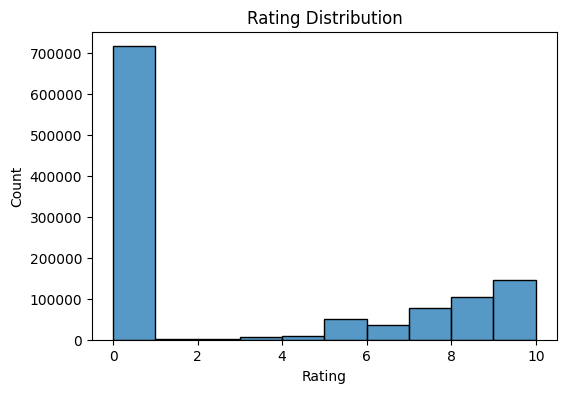

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(ratings, x= 'Book-Rating', bins = 10, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [ ]:
ratings_clean = ratings[ratings['Book-Rating'] > 0]

In [ ]:
active_users = ratings_clean['User-ID'].value_counts()
active_users = active_users[active_users >= 50].index
ratings_clean = ratings_clean[ratings_clean['User-ID'].isin(active_users)]

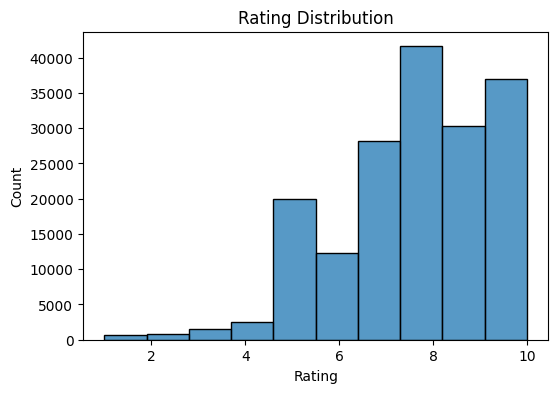

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(ratings_clean, x= 'Book-Rating', bins = 10, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [ ]:
top_books = ratings_clean['ISBN'].value_counts().head(10)

In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_clean[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from sklearn.metrics import ndcg_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressorD
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
model_knn = KNNBasic()
model_knn.fit(trainset)

model_svd = SVD()
model_svd.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
df_ml = ratings_clean.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')
df_ml['user_enc'] = LabelEncoder().fit_transform(df_ml['User-ID'])
df_ml['book_enc'] = LabelEncoder().fit_transform(df_ml['ISBN'])

In [ ]:
X = df_ml[['user_enc', 'book_enc']]
y = df_ml['Book-Rating']


In [ ]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = sk_train_test_split(X, y, test_size=0.2, random_state=42)
dtree = DecisionTreeRegressor(max_depth=10)
dtree.fit(X_train_ml, y_train_ml)

DecisionTreeRegressor(max_depth=10)

In [ ]:
user_id_map = dict(zip(df_ml['User-ID'], df_ml['user_enc']))
book_id_map = dict(zip(df_ml['ISBN'], df_ml['book_enc']))
book_title_map = dict(zip(books['Book-Title'].str.lower(), books['ISBN']))
book_info_map = dict(zip(books['ISBN'], books['Book-Title']))


In [ ]:
def get_recommendations(user_id=None, book_title=None, model_type="SVD", top_n=5):
    model_type = model_type.upper()
    used_isbns = ratings_clean['ISBN'].unique()

    if book_title:
        book_title = book_title.lower().strip()
        isbn = book_title_map.get(book_title)
        if not isbn:
            return f"Book '{book_title}' not found."

    if model_type == "SVD":
        model = model_svd
    elif model_type == "KNN":
        model = model_knn
    elif model_type == "DT":
        model = dtree
    else:
        return "Invalid model type. Choose from SVD, KNN, or DT."

    if user_id and model_type in ["SVD", "KNN"]:
        rated_books = ratings_clean[ratings_clean['User-ID'] == user_id]['ISBN'].tolist()
        candidate_books = [isbn for isbn in used_isbns if isbn not in rated_books]
        preds = [model.predict(user_id, isbn) for isbn in candidate_books]
        top_preds = sorted(preds, key=lambda x: x.est, reverse=True)[:top_n]
        return [(book_info_map[p.iid], round(p.est, 2)) for p in top_preds]

    elif user_id and model_type == "DT":
        if user_id not in user_id_map:
            return "User not found."
        user_enc = user_id_map[user_id]
        candidate_books = [isbn for isbn in used_isbns if isbn in book_id_map]
        book_encs = [book_id_map[isbn] for isbn in candidate_books]
        X_pred = pd.DataFrame({'user_enc': [user_enc]*len(book_encs), 'book_enc': book_encs})
        preds = dtree.predict(X_pred)
        results = pd.DataFrame({'ISBN': candidate_books, 'Rating': preds})
        results = results.sort_values(by='Rating', ascending=False).head(top_n)
        return [(book_info_map[isbn], round(rating, 2)) for isbn, rating in zip(results['ISBN'], results['Rating'])]

    elif book_title:
        book_data = books[books['Book-Title'].str.lower() == book_title]
        if book_data.empty:
            return "Book not found."
        author = book_data.iloc[0]['Book-Author']
        publisher = book_data.iloc[0]['Publisher']
        similar_books = books[(books['Book-Author'] == author) | (books['Publisher'] == publisher)]
        rated = ratings_clean.groupby('ISBN')['Book-Rating'].mean().reset_index()
        ranked_books = similar_books.merge(rated, on='ISBN', how='left').sort_values(by='Book-Rating', ascending=False)
        return list(ranked_books[['Book-Title', 'Book-Rating']].dropna().head(top_n).itertuples(index=False, name=None))

    return "Please provide at least a user_id or book title."
# Evaluate models and display metrics
print("\n--- Model Evaluation ---")


--- Model Evaluation ---


In [ ]:
# Evaluate SVD
pred_svd = model_svd.test(testset)
y_true_svd = np.array([pred.r_ui for pred in pred_svd])
y_est_svd = np.array([pred.est for pred in pred_svd])
rmse_svd = rmse(pred_svd, verbose=False)
ndcg_svd = ndcg_score([y_true_svd], [y_est_svd])
f1_svd = f1_score(y_true_svd.round(), y_est_svd.round(), average='macro')

In [ ]:
# Evaluate KNN
pred_knn = model_knn.test(testset)
y_true_knn = np.array([pred.r_ui for pred in pred_knn])
y_est_knn = np.array([pred.est for pred in pred_knn])
rmse_knn = rmse(pred_knn, verbose=False)
ndcg_knn = ndcg_score([y_true_knn], [y_est_knn])
f1_knn = f1_score(y_true_knn.round(), y_est_knn.round(), average='macro')

In [ ]:
# Evaluate Decision Tree
y_pred_dt = dtree.predict(X_test_ml)
rmse_dt = mean_squared_error(y_test_ml, y_pred_dt)
ndcg_dt = ndcg_score([y_test_ml], [y_pred_dt])
f1_dt = f1_score(y_test_ml.round(), y_pred_dt.round(), average='macro')

In [ ]:
# Display metrics
results_df = pd.DataFrame({
    "RMSE": [rmse_svd, rmse_knn, rmse_dt],
    "NDCG": [ndcg_svd, ndcg_knn, ndcg_dt],
    "F1-Score": [f1_svd, f1_knn, f1_dt]
}, index=["SVD", "KNN", "Decision Tree"])

print("\nModel Comparison:")
print(results_df)


Model Comparison:
                   RMSE      NDCG  F1-Score
SVD            1.530896  0.992086  0.162366
KNN            1.920273  0.982417  0.089528
Decision Tree  2.816484  0.988102  0.125011


In [ ]:
books_clean = books.copy()
books_clean['Book-Author'] = books_clean['Book-Author'].fillna('Unknown')
books_clean['Publisher'] = books_clean['Publisher'].fillna('Unknown')

In [ ]:
books_clean['Book-Title'].duplicated().sum()

29225

In [ ]:
books_clean.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books_clean[books_clean['Book-Author'] == 'William Shakespeare']

NameError: name 'books_clean' is not defined

In [ ]:
get_recommendations(book_title="Harry Potter and the Chamber of Secrets", user=1234, model_type="SVD")

NameError: name 'get_recommendations' is not defined

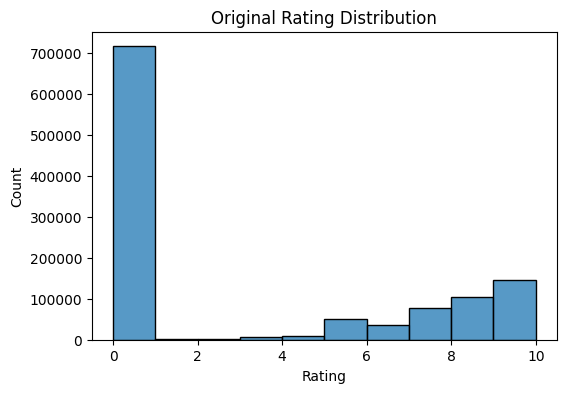

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(ratings, x= 'Book-Rating', bins = 10, kde=False)
plt.title("Original Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(ratings_clean, x= 'Book-Rating', bins = 10, kde=False)
plt.title("Cleaned Rating Distribution (>0)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

NameError: name 'ratings_clean' is not defined

<Figure size 600x400 with 0 Axes>

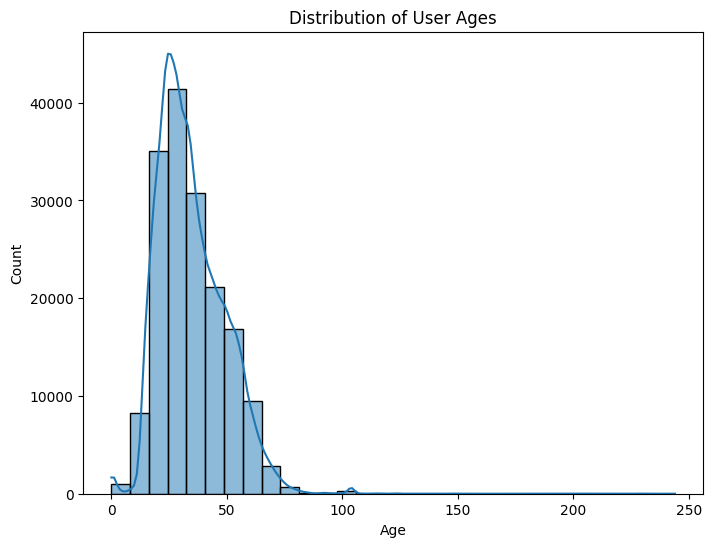

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(users['Age'].dropna(), bins=30, kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

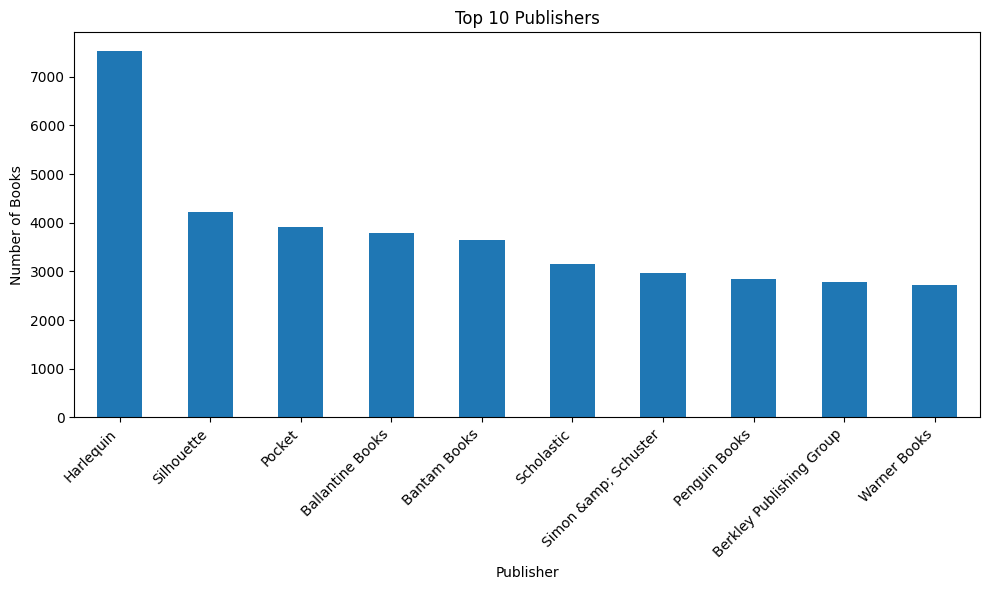

In [ ]:
plt.figure(figsize=(10, 6))
books['Publisher'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

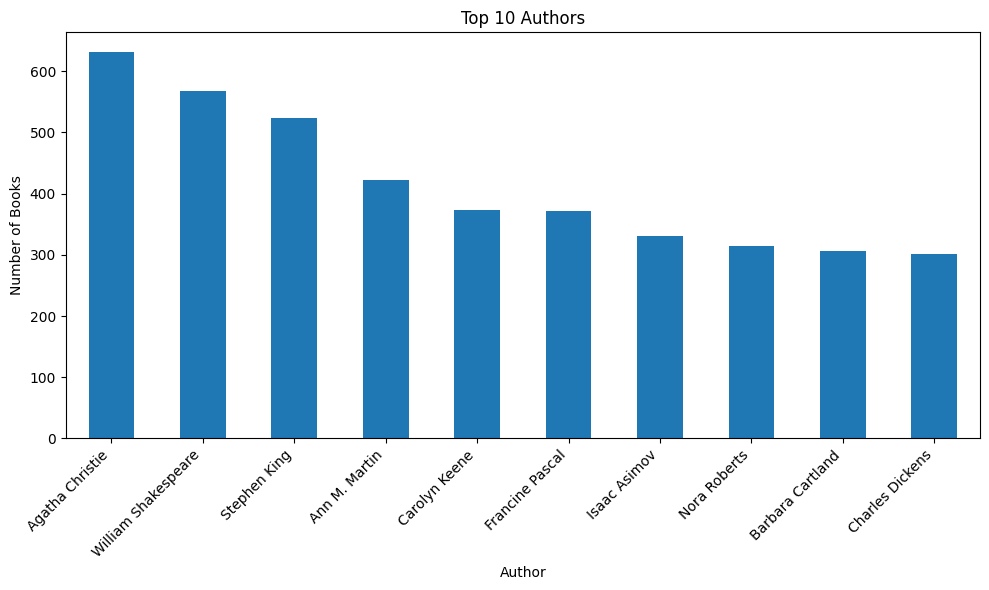

In [ ]:
plt.figure(figsize=(10, 6))
books['Book-Author'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Authors')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

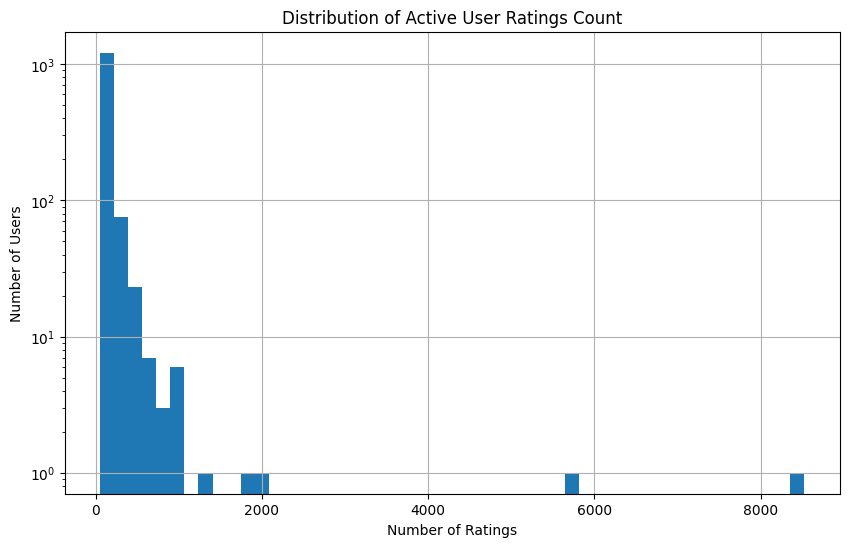

In [ ]:
plt.figure(figsize=(10, 6))
ratings_clean['User-ID'].value_counts().hist(bins=50)
plt.title('Distribution of Active User Ratings Count')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log') # Use log scale for better visualization of skewed data
plt.show()

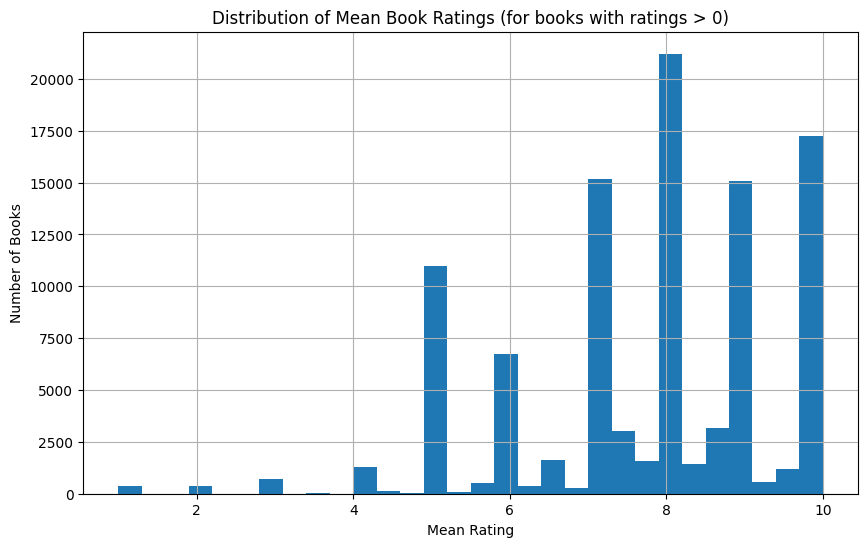

In [ ]:
plt.figure(figsize=(10, 6))
ratings_clean.groupby('ISBN')['Book-Rating'].mean().hist(bins=30)
plt.title('Distribution of Mean Book Ratings (for books with ratings > 0)')
plt.xlabel('Mean Rating')
plt.ylabel('Number of Books')
plt.show()